# Compute N<sub>2</sub> fluxes from ERA5 heat fluxes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import intake
import cdsapi

import regrid_tools
import config
import solubility
import util

In [3]:
year0, yearf = 1984, 2020
scaleby = 1 / 1.3
shift_time = 0.

## Get the heat flux

Get data from ECMWF servers using `cdsapi`. Generate a command here:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form


Interpolate onto a more sensible grid. The ERA5 data is already interpolated from the native Gaussian grid using bilinear interpolation. They serve the data with values at -90°N and 90°N: the data in these top and bottom rows is all identical.

Use `sst` field to generate land mask. The following test passes:
```python
for i in range(len(ds.time)):
    assert (ds.tos.isel(time=0).isnull() == ds.tos.isel(time=i).isnull()).all()
```

Variable definitions (see [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)):
```
mslhf: Mean surface latent heat flux
msnlwrf: Mean surface net long-wave radiation flux
msnswrf: Mean surface net short-wave radiation flux
msshf: Mean surface sensible heat flux
sst: Sea surface temperature
```

| Variable         | Short Name | Units     | Description |
| ---------------- | ---------- | --------- | ----------- |
|Mean surface latent heat flux | `mslhf` | W m<sup>-2</sup> | This parameter is the transfer of latent heat (resulting from water phase changes, such as evaporation or condensation) between the Earth's surface and the atmosphere through the effects of turbulent air motion. Evaporation from the Earth's surface represents a transfer of energy from the surface to the atmosphere. This parameter is a mean over a particular time period (the processing period) which depends on the data extracted. For the monthly averaged reanalysis and the monthly averaged ensemble members, the processing period is the complete, whole month. For the monthly averaged reanalysis by hour of day, the processing period is 1 hour for every day of the month and for the monthly averaged ensemble members by hour of day, the processing period is 3 hours for every day of the month. The ECMWF convention for vertical fluxes is positive downwards.|
| Mean surface net long-wave radiation flux| `msnlwrf` | W m<sup>-2</sup> |Thermal radiation (also known as longwave or terrestrial radiation) refers to radiation emitted by the atmosphere, clouds and the surface of the Earth. This parameter is the difference between downward and upward thermal radiation at the surface of the Earth. It is the amount of radiation passing through a horizontal plane. The atmosphere and clouds emit thermal radiation in all directions, some of which reaches the surface as downward thermal radiation. The upward thermal radiation at the surface consists of thermal radiation emitted by the surface plus the fraction of downwards thermal radiation reflected upward by the surface. This parameter is a mean over a particular time period (the processing period) which depends on the data extracted. For the monthly averaged reanalysis and the monthly averaged ensemble members, the processing period is the complete, whole month. For the monthly averaged reanalysis by hour of day, the processing period is 1 hour for every day of the month and for the monthly averaged ensemble members by hour of day, the processing period is 3 hours for every day of the month. The ECMWF convention for vertical fluxes is positive downwards.|
| Mean surface net short-wave radiation flux | `msnswrf` | W m<sup>-2</sup> | This parameter is the amount of solar radiation (also known as shortwave radiation) that reaches a horizontal plane at the surface of the Earth (both direct and diffuse) minus the amount reflected by the Earth's surface (which is governed by the albedo). Radiation from the Sun (solar, or shortwave, radiation) is partly reflected back to space by clouds and particles in the atmosphere (aerosols) and some of it is absorbed. The remainder is incident on the Earth's surface, where some of it is reflected. This parameter is a mean over a particular time period (the processing period) which depends on the data extracted. For the monthly averaged reanalysis and the monthly averaged ensemble members, the processing period is the complete, whole month. For the monthly averaged reanalysis by hour of day, the processing period is 1 hour for every day of the month and for the monthly averaged ensemble members by hour of day, the processing period is 3 hours for every day of the month. The ECMWF convention for vertical fluxes is positive downwards.|
| Mean surface sensible heat flux | `msshf` | W m<sup>-2</sup>  | 	This parameter is the transfer of heat between the Earth's surface and the atmosphere through the effects of turbulent air motion (but excluding any heat transfer resulting from condensation or evaporation). The magnitude of the sensible heat flux is governed by the difference in temperature between the surface and the overlying atmosphere, wind speed and the surface roughness. For example, cold air overlying a warm surface would produce a sensible heat flux from the land (or ocean) into the atmosphere. This parameter is a mean over a particular time period (the processing period) which depends on the data extracted. For the monthly averaged reanalysis and the monthly averaged ensemble members, the processing period is the complete, whole month. For the monthly averaged reanalysis by hour of day, the processing period is 1 hour for every day of the month and for the monthly averaged ensemble members by hour of day, the processing period is 3 hours for every day of the month. The ECMWF convention for vertical fluxes is positive downwards.|

In [4]:
%%time
import urllib3
urllib3.disable_warnings()

file_out = f"{config.intake_cachedir}/era5.mean_surface_heat_fluxes.{year0:04d}-{yearf:04d}.nc"

if not os.path.exists(file_out):
    
    try:
        with open("ecmwf_credentials.yaml") as fid:
            credentials = yaml.safe_load(fid)
    except:
        raise    
    
    c = cdsapi.Client(**credentials)
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'format': 'netcdf',
            'variable': [
                'mean_surface_latent_heat_flux', 
                'mean_surface_net_long_wave_radiation_flux', 
                'mean_surface_net_short_wave_radiation_flux',
                'mean_surface_sensible_heat_flux',
                'sea_surface_temperature',
            ],
            'year': [f"{y:04d}" for y in range(year0, yearf+1)],
            'month': [f"{m:02d}" for m in range(1, 13)],
            'time': '00:00',
            'product_type': 'monthly_averaged_reanalysis',
        },
        file_out)

ds = xr.open_dataset(file_out)
grid = util.generate_latlon_grid(1440, 720)

# turn the world right-side up
ds = ds.reindex(latitude=ds.latitude[::-1])

# mask out land
ds = ds.where(ds.sst)

# compute total net heat flux
ds["hfds"] = ds.mslhf + ds.msnlwrf + ds.msnswrf + ds.msshf
ds.hfds.attrs = ds.mslhf.attrs
ds.hfds.attrs["long_name"] = "Net surface heat flux"

ds = ds.rename({"sst": "tos"})
ds = ds[["hfds", "tos"]].interp(longitude=grid.lon, latitude=grid.lat)
ds["area"] = grid.area.where(ds.tos.isel(time=0).notnull()).fillna(0.)

with xr.set_options(keep_attrs=True):
    ds['tos'] = ds.tos - solubility.T0_Kelvin
    ds.tos.attrs['units'] = 'degC'

ds

CPU times: user 1min 4s, sys: 35.8 s, total: 1min 40s
Wall time: 2min 22s


<xarray.Dataset>
Dimensions:    (time: 444, lat: 720, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2020-12-01
    longitude  (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    latitude   (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat        (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    hfds       (time, lat, lon) float64 5.328 5.329 5.328 ... -31.94 -31.94 nan
    tos        (time, lat, lon) float64 nan nan nan nan ... -1.689 -1.689 nan
    area       (lat, lon) float64 0.0 0.0 0.0 0.0 ... 1.686e+06 1.686e+06 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-14 23:13:27 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

### Examine this dataset

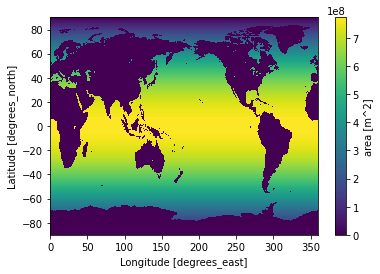

In [5]:
ds.area.plot()

## Get WOA salinity data

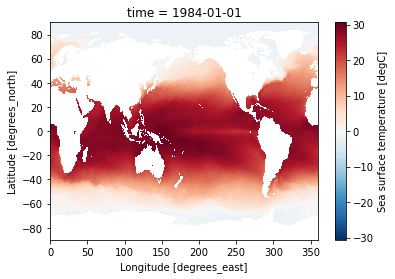

In [6]:
ds.tos.isel(time=0).plot()

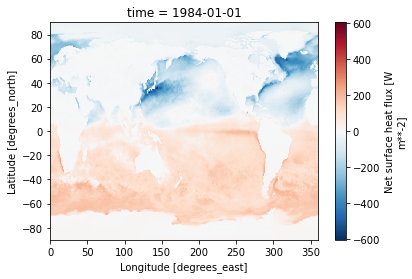

In [7]:
ds.hfds.isel(time=0).plot()

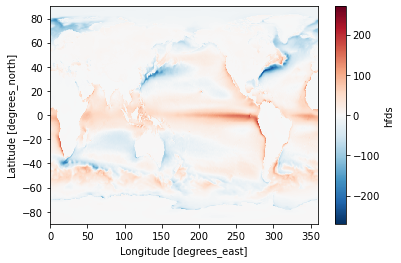

In [8]:
ds.hfds.mean('time').plot()

In [9]:
cat = intake.open_catalog("catalogs/woa2018-catalog.yml")
print(cat.yaml())

sources:
  woa2018-catalog:
    args:
      path: catalogs/woa2018-catalog.yml
    description: World Ocean Atlas, v2018
    driver: intake.catalog.local.YAMLFileCatalog
    metadata: {}



In [10]:
%%time
def retrieve_dataset(value):
    try:
        ds = cat.salinity(time_code=value).to_dask().isel(depth=0, drop=True)
    except Exception:
        ds = None
        raise
    return ds


ds_list = list(map(retrieve_dataset, np.arange(1, 13)))
ds_woa_mon = xr.concat(ds_list, dim='time', compat='override', coords='minimal').squeeze().compute()
ds_woa_mon = ds_woa_mon[["s_an"]]
ds_woa_mon

CPU times: user 513 ms, sys: 68.5 ms, total: 581 ms
Wall time: 3.5 s


<xarray.Dataset>
Dimensions:  (time: 12, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) float64 372.5 373.5 374.5 375.5 ... 380.5 381.5 382.5 383.5
Data variables:
    s_an     (time, lat, lon) float32 nan nan nan nan ... 31.15 31.15 31.15
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_salin...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, D. Seidov, T....
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

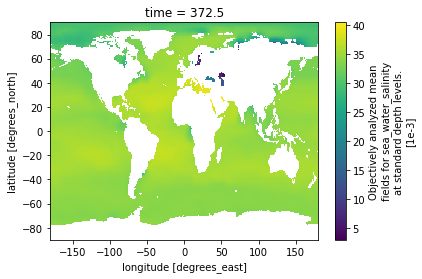

In [11]:
ds_woa_mon.s_an.isel(time=0).plot()

In [12]:
woa_grid = regrid_tools.grid("latlon", nx=360, ny=180, lon0=-180.)
woa_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc


grid: latlon_latlon_1.0x1.0_lon0=-180.0
dims: (180, 360)
file: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc

In [13]:
era5_grid = regrid_tools.grid("latlon", nx=1440, ny=720, lon0=0.)
era5_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_0.25x0.25_lon0=0.0.nc


grid: latlon_latlon_0.25x0.25_lon0=0.0
dims: (720, 1440)
file: /glade/scratch/mclong/tmp/regridding/latlon_0.25x0.25_lon0=0.0.nc

In [14]:
regrid_woa_to_era5 = regrid_tools.regridder(woa_grid, era5_grid, method="conserve", clobber=False)
regrid_woa_to_era5

source grid dims: (180, 360)
destination grid dims: (720, 1440)


regridder latlon_1.0x1.0_lon0=-180.0.nc --> latlon_0.25x0.25_lon0=0.0.nc

In [15]:
ds_woa_mon_era5 = regrid_woa_to_era5(ds_woa_mon)
ds_woa_mon_era5

<xarray.Dataset>
Dimensions:  (time: 12, lat: 720, lon: 1440)
Coordinates:
  * time     (time) float64 372.5 373.5 374.5 375.5 ... 380.5 381.5 382.5 383.5
Dimensions without coordinates: lat, lon
Data variables:
    s_an     (time, lat, lon) float64 nan nan nan nan ... 31.15 31.15 31.15
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_salin...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, D. Seidov, T....
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

In [16]:
salinity_data = np.concatenate([ds_woa_mon_era5.s_an.data for i in range(year0, yearf+1)], axis=0)
ds["sos"] = xr.DataArray(salinity_data, dims=ds.tos.dims, coords=ds.tos.coords)
ds

<xarray.Dataset>
Dimensions:    (time: 444, lat: 720, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2020-12-01
    longitude  (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    latitude   (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat        (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    hfds       (time, lat, lon) float64 5.328 5.329 5.328 ... -31.94 -31.94 nan
    tos        (time, lat, lon) float64 nan nan nan nan ... -1.689 -1.689 nan
    area       (lat, lon) float64 0.0 0.0 0.0 0.0 ... 1.686e+06 1.686e+06 0.0
    sos        (time, lat, lon) float64 nan nan nan nan ... 31.15 31.15 31.15
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-14 23:13:27 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [17]:
ds = util.compute_fgn2(ds, scaleby).rename({'fgn2': 'SFN2_OCN'})
ds['SFN2_OCN'].attrs['units'] = 'mol/m^2/s'
ds

<xarray.Dataset>
Dimensions:    (time: 444, lat: 720, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2020-12-01
    longitude  (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    latitude   (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat        (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    hfds       (time, lat, lon) float64 5.328 5.329 5.328 ... -31.94 -31.94 nan
    tos        (time, lat, lon) float64 nan nan nan nan ... -1.689 -1.689 nan
    area       (lat, lon) float64 0.0 0.0 0.0 0.0 ... 1.686e+06 1.686e+06 0.0
    sos        (time, lat, lon) float64 nan nan nan nan ... 31.15 31.15 31.15
    SFN2_OCN   (time, lat, lon) float64 nan nan nan ... -1.038e-07 nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-14 23:13:27 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

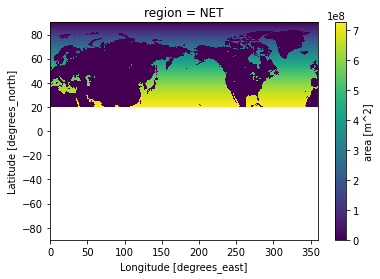

In [18]:
region = xr.DataArray(['NET', 'SET'], dims=('region'), name='region')
masked_area = xr.concat([
    ds.area.where(ds.lat >= 20),
    ds.area.where(ds.lat <= -20),    
],
    dim=region,
)
masked_area.isel(region=0).plot()

In [19]:
mols_to_Tmolmon = 86400. * 365. / 12 * 1e-12

vars_mean = ['tos', 'hfds']
vars_aint = ['SFN2_OCN']
with xr.set_options(keep_attrs=True):
    ds_mon_clim = ds.groupby('time.month').mean('time')    
    ds_mon_clim_region = (ds_mon_clim[vars_mean] * masked_area).sum(['lat', 'lon']) / masked_area.sum(['lat', 'lon'])
    ds_mon_clim_region = xr.merge([
        ds_mon_clim_region,
        (ds_mon_clim[vars_aint] * masked_area).sum(['lat', 'lon']),
    ])
    ds_mon_clim_region['SFN2_OCN'] = ds_mon_clim_region.SFN2_OCN * mols_to_Tmolmon
    ds_mon_clim_region.SFN2_OCN.attrs['units'] = 'Tmol mon${-1}$'
ds_mon_clim_region

<xarray.Dataset>
Dimensions:   (month: 12, region: 2)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region    (region) <U3 'NET' 'SET'
Data variables:
    tos       (month, region) float64 12.39 13.59 11.83 ... 11.26 13.48 12.42
    hfds      (month, region) float64 -136.3 117.2 -94.35 ... 94.06 -150.1 126.0
    SFN2_OCN  (month, region) float64 -54.07 80.41 -39.69 ... 65.87 -56.77 89.0

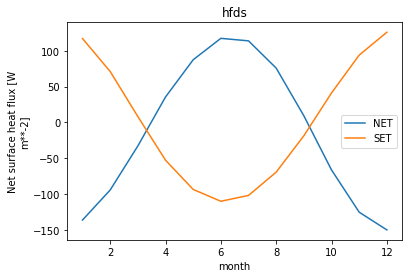

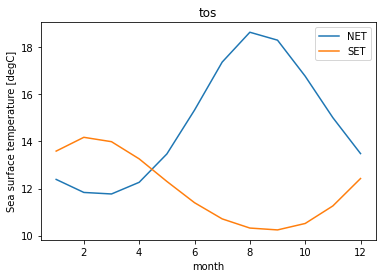

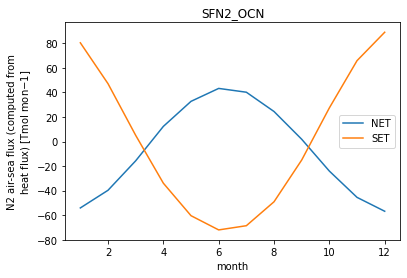

In [20]:
for v in ['hfds', 'tos', 'SFN2_OCN']:
    plt.figure()
    for i in range(ds_mon_clim_region.sizes['region']):
        ds_mon_clim_region[v].isel(region=i).plot(label=ds_mon_clim_region.region.isel(region=i).values)
    plt.legend();
    plt.title(v)

In [21]:
(ds_mon_clim * masked_area).sum(['lat', 'lon']) / masked_area.sum(['lat', 'lon'])

<xarray.Dataset>
Dimensions:   (month: 12, region: 2)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region    (region) <U3 'NET' 'SET'
Data variables:
    hfds      (month, region) float64 -136.3 117.2 -94.35 ... 94.06 -150.1 126.0
    tos       (month, region) float64 12.39 13.59 11.83 ... 11.26 13.48 12.42
    area      (month, region) float64 5.387e+08 5.487e+08 ... 5.487e+08
    sos       (month, region) float64 32.57 34.43 32.65 ... 34.49 32.56 34.46
    SFN2_OCN  (month, region) float64 -2.377e-07 2.213e-07 ... 2.449e-07

In [22]:
dst_grid = regrid_tools.grid("latlon", **config.config_dict["flux-dst-grid-kwargs"])
dst_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc


grid: latlon_latlon_1.0x1.0_lon0=-180.0
dims: (180, 360)
file: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc

In [23]:
regrid_obj = regrid_tools.regridder(era5_grid, dst_grid, method="conserve", clobber=False)
regrid_obj

source grid dims: (720, 1440)
destination grid dims: (180, 360)


regridder latlon_0.25x0.25_lon0=0.0.nc --> latlon_1.0x1.0_lon0=-180.0.nc

In [24]:
dso = util.generate_latlon_grid(**config.config_dict["flux-dst-grid-kwargs"])[["area"]]
dso['SFN2_OCN'] = regrid_obj(ds['SFN2_OCN'])
dso

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, time: 444)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time      (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2020-12-01
Data variables:
    area      (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    SFN2_OCN  (time, lat, lon) float64 nan nan nan ... -1.154e-07 -1.156e-07

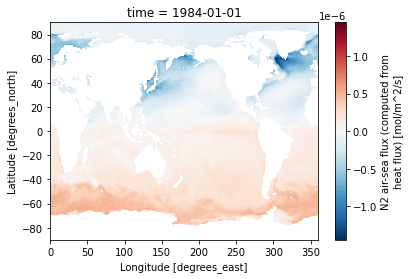

In [25]:
ds.SFN2_OCN.isel(time=0).plot()

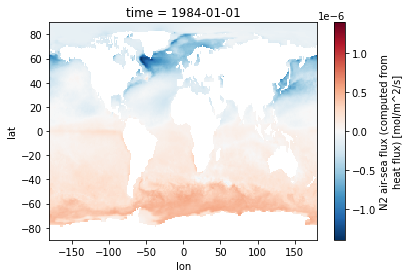

In [26]:
dso.SFN2_OCN.isel(time=0).plot()

In [27]:
time, time_bnd = util.gen_midmonth_cftime_coord((year0, yearf), shift_time=shift_time)
dso['time'] = time
dso[time.bounds] = time_bnd
dso

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 444, d2: 2)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time       (time) object 1984-01-16 12:00:00 ... 2020-12-16 12:00:00
Dimensions without coordinates: d2
Data variables:
    area       (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    SFN2_OCN   (time, lat, lon) float64 nan nan nan ... -1.154e-07 -1.156e-07
    time_bnds  (time, d2) object 1984-01-01 00:00:00 ... 2021-01-01 00:00:00

In [28]:
file_out = f"{config.flux_product_dir}/SFN2_OCN.era5-shf.shft_{shift_time:0.0f}d.scale_{scaleby:0.2f}.{year0}-{yearf}.nc"

dso.attrs = {}
dso.attrs['note'] = 'Heat flux from ERA5 Reanalysis: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means'
util.to_netcdf_clean(dso, file_out)

------------------------------
Writing /glade/work/mclong/sno-analysis/flux-products/SFN2_OCN.era5-shf.shft_0d.scale_0.77.1984-2020.nc
netcdf SFN2_OCN.era5-shf.shft_0d.scale_0.77.1984-2020 {
dimensions:
	lat = 180 ;
	lon = 360 ;
	time = 444 ;
	d2 = 2 ;
variables:
	double lat(lat) ;
	double lon(lon) ;
	float area(lat, lon) ;
		area:_FillValue = 9.96921e+36f ;
		area:units = "m^2" ;
		area:long_name = "area" ;
	double time(time) ;
		time:shift_time = 0. ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1984-01-01" ;
		time:calendar = "gregorian" ;
	float SFN2_OCN(time, lat, lon) ;
		SFN2_OCN:_FillValue = 9.96921e+36f ;
		SFN2_OCN:units = "mol/m^2/s" ;
		SFN2_OCN:long_name = "N2 air-sea flux (computed from heat flux)" ;
		SFN2_OCN:note = "fluxes computed using F = c * (-dC/dT) * Q/Cp; c = 0.7692" ;
	double time_bnds(time, d2) ;

// global attributes:
		:note = "Heat flux from ERA5 Reanalysis: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly

In [29]:
curator = util.curate_flux_products()
curator.add_source(
        key=f"SFN2_OCN.era5_shf",
        urlpath=file_out,
        description='N2 flux computed from ERA5 heat flux',
    )